In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

# Import Neural Networks
import multiresunet
import unet_plus_plus
import unet
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Read in the data

In [2]:
filenames = glob('lgg-mri-segmentation/kaggle_3m/*/*.tif')
masknames = glob('lgg-mri-segmentation/kaggle_3m/*/*mask.tif')

imagenames = [x for x in filenames if x not in masknames]

# Load Data
all_X = []
all_Y = []

for i, f in enumerate(imagenames):
    print(('\r %d / %d' % (i, len(imagenames))), end='')
    img = cv2.imread(f)
    # Only care about "post-contrast" channel
    img = img[:,:,1] / 255
    mask_name = f.replace('.tif', '_mask.tif')
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
    mask = mask / 255

    img = np.expand_dims(img, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    all_X += [img]
    all_Y += [mask]

print('\n')

all_X = np.array(all_X)
all_Y = np.array(all_Y)

train_X, test_X, train_Y, test_Y = train_test_split(all_X, all_Y)

 3928 / 3929



# Useful Definitions

In [11]:
# Useful Definitions
def dice_loss(y_true, y_pred):
    #ypred = K.greater_equal(y_pred,0.2)
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def bce_logdice_loss(y_true, y_pred):

    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

# Train Model

In [4]:
#model = unet.unet()
model = unet_plus_plus.unetpp()
model.compile(optimizer='adam', loss=bce_logdice_loss, metrics=[dice_coef, 'accuracy'])

checkpoint1 = ModelCheckpoint('unetpp_test.h5', monitor='val_dice_coef', verbose=1, save_best_only=False, mode='max', period=1)  

history = model.fit(train_X, 
                    train_Y, 
                    epochs=5, 
                    verbose=1, 
                    validation_data=(test_X, test_Y), 
                    callbacks=[checkpoint1])

Train on 2946 samples, validate on 983 samples
Epoch 1/5
2944/2946 [============================>.] - ETA: 1s - loss: 1.9368 - dice_coef: 0.1758 - accuracy: 0.9238 
Epoch 00001: saving model to unetpp_test.h5
2946/2946 [==============================] - 1882s 639ms/sample - loss: 1.9363 - dice_coef: 0.1768 - accuracy: 0.9238 - val_loss: 1.4861 - val_dice_coef: 0.2625 - val_accuracy: 0.9629
Epoch 2/5
2944/2946 [============================>.] - ETA: 1s - loss: 1.2123 - dice_coef: 0.2718 - accuracy: 0.9836 
Epoch 00002: saving model to unetpp_test.h5
2946/2946 [==============================] - 1756s 596ms/sample - loss: 1.2129 - dice_coef: 0.2702 - accuracy: 0.9836 - val_loss: 1.6705 - val_dice_coef: 0.2129 - val_accuracy: 0.9494
Epoch 3/5
2944/2946 [============================>.] - ETA: 1s - loss: 1.0460 - dice_coef: 0.3198 - accuracy: 0.9864 
Epoch 00003: saving model to unetpp_test.h5
2946/2946 [==============================] - 1716s 582ms/sample - loss: 1.0488 - dice_coef: 0.3174 

(1, 256, 256, 1)


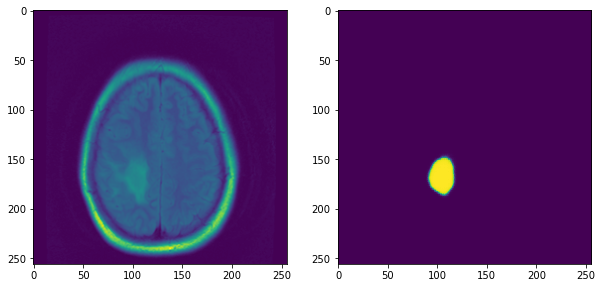

In [15]:
model = load_model('unet_test.h5', custom_objects={'bce_logdice_loss' : bce_logdice_loss, 'dice_coef': dice_coef})

img = test_X[np.random.choice(range(len(test_X)), size=1)]
img = np.expand_dims(test_X[0], axis=0)
print(np.shape(img))
#img = img, axis=0)

pred = model.predict(img)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.squeeze(img))
plt.subplot(122)
plt.imshow(np.squeeze(pred))
plt.show()